In [1]:
import os
from datetime import date
os.chdir(os.getcwd().replace("\\notebooks", ""))

In [2]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
from scipy.stats import nct

from savings_plan_projecter.plotting import new_plot, cp_observation_period
from savings_plan_projecter.simulating import simulate_share_price, infer_nct_parameters

In [3]:
df = pd.read_csv(r"data\input\^GSPC_2005-01-01-2023-05-19.csv", index_col="DATE")
df.head()

,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,ABS_CHANGE,PERC_CHANGE,IS_POSITIVE_CHANGE
DATE,,,,,,,,,
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000,-9.840088,-0.811942,False
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000,-14.029907,-1.167136,False
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000,-4.310059,-0.362784,False
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000,4.150024,0.350586,True
2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1186.189941,1477900000,-1.700073,-0.143117,False


[]

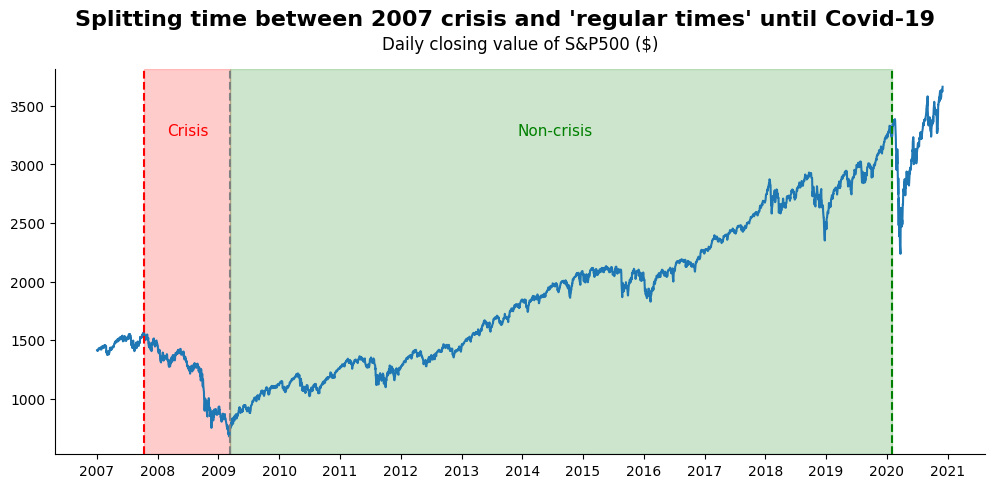

In [4]:
_, ax = new_plot(
    title="Splitting time between 2007 crisis and 'regular times' until Covid-19",
    subtitle="Daily closing value of S&P500 ($)",
    figsize=(12, 5),
)

observation_period = df.index.to_series().between("2007-01-01", "2020-12-01")
ax.plot(
    pd.to_datetime(df[observation_period].index),
    df.loc[observation_period, "CLOSE"],
)
crisis_start_date = date(2007, 10, 10)
crisis_end_date = date(2009, 3, 10)
non_crisis_end_date = date(2020, 2, 1)

ax.axvline(crisis_start_date, c="red", ls="dashed")
ax.axvline(crisis_end_date, c="gray", ls="dashed")
ax.axvline(non_crisis_end_date, c="green", ls="dashed")
ax.axvspan(xmin=crisis_start_date, xmax=crisis_end_date, color="red", alpha=0.2)
ax.axvspan(xmin=crisis_end_date, xmax=non_crisis_end_date, color="green", alpha=0.2)

ax.text(
    x=date(2008, 3, 1),
    y=3250,
    s="Crisis",
    fontdict={"fontsize": 11, "color": "red"},
)
ax.text(
    x=date(2013, 12, 1),
    y=3250,
    s="Non-crisis",
    fontdict={"fontsize": 11, "color": "green"},
)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.plot()

In [5]:
df["IS_CRISIS"] = pd.to_datetime(df.index).to_series().dt.date.between(crisis_start_date, crisis_end_date)
df["IS_REGULAR"] = pd.to_datetime(df.index).to_series().dt.date.between(crisis_end_date, non_crisis_end_date)

In [30]:
best_params = infer_nct_parameters(df.loc[df.IS_CRISIS, "PERC_CHANGE"])

distribution = nct(*best_params)
simulated_values = distribution.rvs(10000)

x = np.linspace(distribution.ppf(0.01),
                distribution.ppf(0.99), 100)

print(simulated_values.mean())
print(df.loc[df.IS_CRISIS, "PERC_CHANGE"].mean())

-0.2619343164810937
-0.16530671413734166


In [31]:
print(best_params)

[2.4914771572037884, -0.16530049142359796, 0.13039541105324504, 1.3330998409668395]


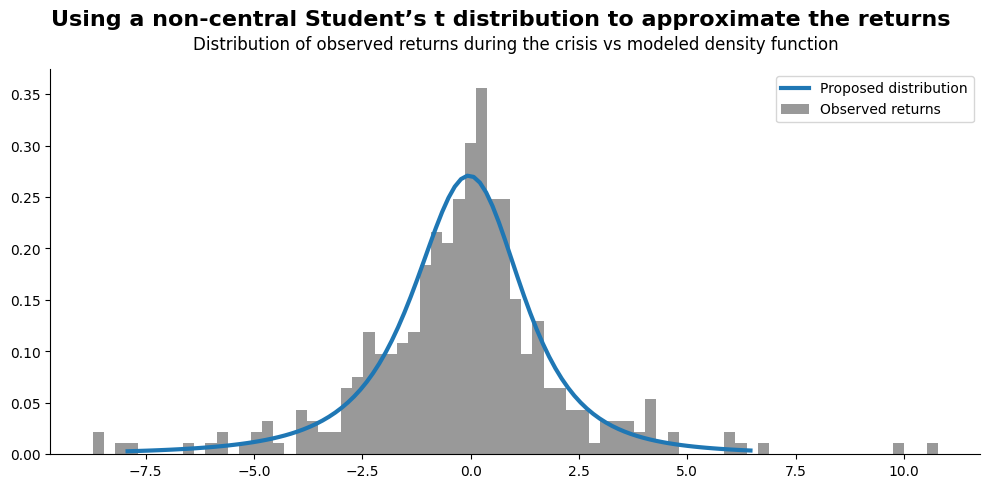

In [8]:
fig, ax = new_plot(
    title="Using a non-central Student’s t distribution to approximate the returns",
    subtitle="Distribution of observed returns during the crisis vs modeled density function"
)

ax.plot(x, distribution.pdf(x), lw=3, label="Proposed distribution")
ax.hist(df.loc[df.IS_CRISIS, "PERC_CHANGE"], bins=75, density=True, color="grey", alpha=0.8, label="Observed returns")
ax.legend()

plt.show()

In [11]:
simulations = [simulate_share_price(
    df.loc[df.IS_CRISIS, "CLOSE"].iloc[0],
    distribution,
    356,
    max_val=0.10) for _ in range(101)]

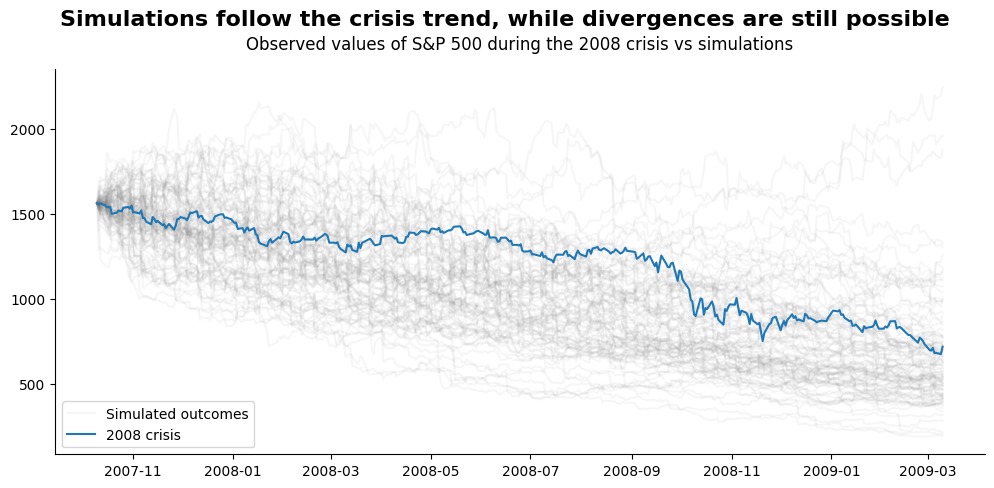

In [10]:
fig, ax = new_plot(
    title="Simulations follow the crisis trend, while divergences are still possible",
    subtitle="Observed values of S&P 500 during the 2008 crisis vs simulations"
)

for index, sim in enumerate(simulations):
    label = None
    if index == 0:
        label = "Simulated outcomes"
    ax.plot(pd.to_datetime(df[df.IS_CRISIS].index), sim, c="grey", label=label, alpha=0.07)
    
ax.plot(pd.to_datetime(df[df.IS_CRISIS].index), df.loc[df.IS_CRISIS, "CLOSE"], label="2008 crisis")
ax.legend()

plt.show()

In [33]:
best_params = infer_nct_parameters(df.loc[df.IS_REGULAR, "PERC_CHANGE"])

best_params[1] = -0.11
distribution = nct(*best_params)
simulated_values = distribution.rvs(10000)

x = np.linspace(distribution.ppf(0.01),
                distribution.ppf(0.99), 100)

print(simulated_values.mean())
print(df.loc[df.IS_REGULAR, "PERC_CHANGE"].mean())

0.03272848765124339
0.047832562314682275


In [34]:
print(best_params)

[2.4659424143119577, -0.11, 0.1416428571893063, 0.5221010884540661]


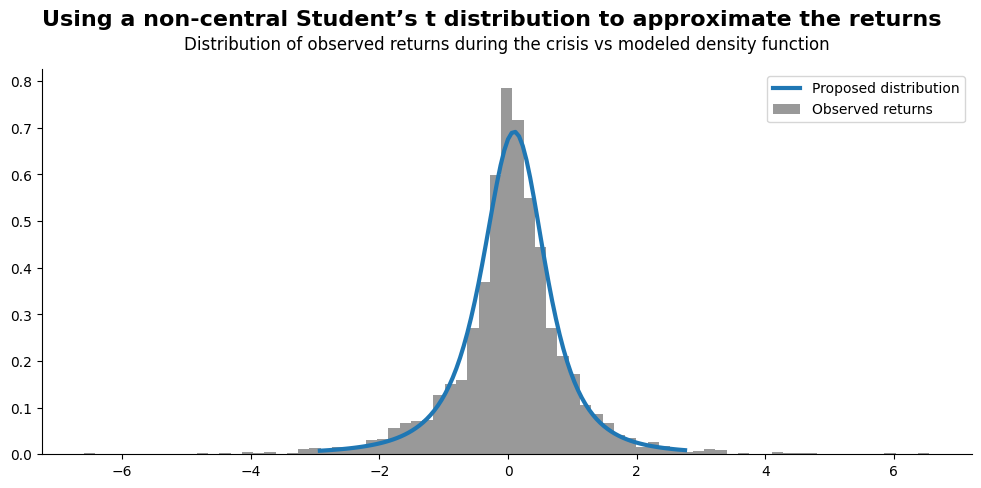

In [25]:
fig, ax = new_plot(
    title="Using a non-central Student’s t distribution to approximate the returns",
    subtitle="Distribution of observed returns during the crisis vs modeled density function"
)

ax.plot(x, distribution.pdf(x), lw=3, label="Proposed distribution")
ax.hist(df.loc[df.IS_REGULAR, "PERC_CHANGE"], bins=75, density=True, color="grey", alpha=0.8, label="Observed returns")
ax.legend()

plt.show()

In [26]:
simulations = [simulate_share_price(
    df.loc[df.IS_REGULAR, "CLOSE"].iloc[0],
    distribution,
    len(df.loc[df.IS_REGULAR, "CLOSE"])
    ) for _ in range(101)]

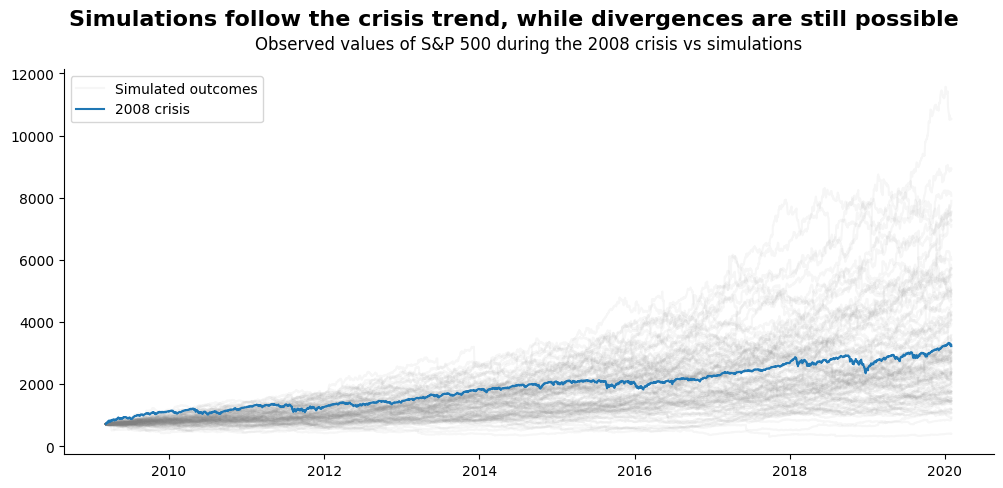

In [27]:
fig, ax = new_plot(
    title="Simulations follow the crisis trend, while divergences are still possible",
    subtitle="Observed values of S&P 500 during the 2008 crisis vs simulations"
)

for index, sim in enumerate(simulations):
    label = None
    if index == 0:
        label = "Simulated outcomes"
    ax.plot(pd.to_datetime(df[df.IS_REGULAR].index), sim, c="grey", label=label, alpha=0.07)
    
ax.plot(pd.to_datetime(df[df.IS_REGULAR].index), df.loc[df.IS_REGULAR, "CLOSE"], label="2008 crisis")
ax.legend()

plt.show()

In [28]:
pd.Series(
    [c[-1] for c in simulations]
).describe()

count      101.000000
mean      3293.616242
std       1993.748294
min        408.252669
25%       1776.331831
50%       2788.199215
75%       4300.473890
max      10540.084898
dtype: float64

In [29]:
df.loc[df.IS_REGULAR, "CLOSE"].iloc[-1]

3225.52001953125